In [62]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score

import warnings
warnings.filterwarnings("ignore", message="Glyph 12 missing from current font.")

from sklearn.decomposition import FastICA as ICA 


Data #1

In [2]:
data_polling = pd.read_stata("Data/cumulative_2006_2018.dta")

In [3]:
inputs = ['year','st','gender', 'age', 'race', 'hispanic', 'educ', 'faminc', 'marstat', 'economy_retro', 'newsint','approval_pres']
targets = ['pid3']

keep = inputs + targets

data_polling = data_polling[(data_polling.year == 2018) & (data_polling.pid3.isin(['Democrat','Republican']) )]

polling = data_polling[keep]

In [4]:
polling.dropna(axis=0, how='any',inplace=True)

/Users/amandahutter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [5]:
pd.options.mode.chained_assignment = None  # default='warn'

polling['age_band'] = np.NaN
polling.loc[ (polling['age'] >= 18) & (polling['age'] <= 29), 'age_band'] = 'Young'
polling.loc[ (polling['age'] >= 30) & (polling['age'] <= 49), 'age_band'] = 'Lower-Middle'
polling.loc[ (polling['age'] >= 50) & (polling['age'] <= 69), 'age_band'] = 'Upper-Middle'
polling.loc[ (polling['age'] >= 70) , 'age_band'] = 'Old'

polling.loc[ polling['pid3'] == "Democrat", "Dem_Ind"] = 1
polling.loc[ polling['pid3'] == 'Republican', "Dem_Ind"] = 0
polling['Dem_Ind'] = polling['Dem_Ind'].astype(int)

categorical_polling = ['st','gender', 'age_band', 'race', 'hispanic', 'educ', 'faminc', 'marstat', 'economy_retro', 'newsint','approval_pres']

In [6]:
polling.head()

,year,st,gender,age,race,hispanic,educ,faminc,marstat,economy_retro,newsint,approval_pres,pid3,age_band,Dem_Ind
392756,2018,OH,Female,58,White,No,Post-Grad,150k+,Married,Stayed About The Same,Only Now And Then,Approve / Somewhat Approve,Republican,Upper-Middle,0
392757,2018,KY,Female,66,White,No,Post-Grad,10k - 20k,Divorced,Stayed About The Same,Most Of The Time,Strongly Disapprove,Democrat,Upper-Middle,1
392758,2018,AZ,Female,88,White,No,High School Graduate,20k - 30k,Widowed,Gotten Much Better,Some Of The Time,Approve / Somewhat Approve,Republican,Old,0
392760,2018,NC,Male,71,White,No,High School Graduate,50k - 60k,Married,Gotten Much Better,Some Of The Time,Strongly Approve,Republican,Old,0
392761,2018,PA,Male,86,White,No,4-Year,60k - 70k,Widowed,Gotten Better / Somewhat Better,Most Of The Time,Strongly Approve,Republican,Old,0


In [7]:
small_polling = polling.sample(n=10000, random_state = 42)

X_polling = small_polling[categorical_polling]

y_polling = small_polling.loc[:,'Dem_Ind']

Data #2

In [8]:
# Originall Retrieved From: http://archive.ics.uci.edu/ml/datasets/Adult
# CSV Retrieved From: https://www.kaggle.com/uciml/adult-census-income
# URL: https://drive.google.com/file/d/1wuWJPeacMhHQSXdITZx1_pktoU-ZRb8n/view?usp=sharing
data_income = pd.read_csv("Data/adult.csv")

print(data_income.shape)

(32561, 15)


In [9]:
# Response Variable 
data_income.loc[ data_income['income'] == ">50K", "income"] = 1
data_income.loc[ data_income['income'] == '<=50K', "income"] = 0
data_income['income'] = data_income['income'].astype(int)

In [10]:
# Feature Engineering
data_income['native_USA'] = 0 
data_income.loc[ data_income['native.country'] == "United-States", "native_USA"] = 1
data_income.loc[ data_income['native.country'] != "United-States", "native_USA"] = 0

In [11]:
data_income['native_USA'].value_counts()

1    29170
0     3391
Name: native_USA, dtype: int64

In [12]:
data_income['age_band'] = np.NaN
data_income.loc[ (data_income['age'] <= 29), 'age_band'] = 'Young'
data_income.loc[ (data_income['age'] >= 30) & (data_income['age'] <= 49), 'age_band'] = 'Lower-Middle'
data_income.loc[ (data_income['age'] >= 50) & (data_income['age'] <= 69), 'age_band'] = 'Upper-Middle'
data_income.loc[ (data_income['age'] >= 70) , 'age_band'] = 'Old'

In [13]:
data_income['hours_band'] = np.NaN
data_income.loc[ (data_income['hours.per.week']) < 40, "hours_band"] = 'Low'
data_income.loc[ (data_income['hours.per.week']) == 40, "hours_band"] = 'Average'
data_income.loc[ (data_income['hours.per.week']) > 40, "hours_band"] = 'High'

In [14]:
data_income['hours_band'].value_counts()

Average    15217
High        9581
Low         7763
Name: hours_band, dtype: int64

In [15]:
categorical_income = ['workclass','education','marital.status','occupation','relationship','race','sex','native_USA','age_band','hours_band']


In [16]:
data_income['income'].value_counts()

0    24720
1     7841
Name: income, dtype: int64

In [17]:
small_income = data_income.sample(10000,random_state=42)

In [18]:
X_income = small_income[categorical_income]

y_income = small_income.loc[:,'income']


General Use Functions

In [19]:
from sklearn.preprocessing import OneHotEncoder

def prep_data(X, y, categoricalVars):

    encoder = OneHotEncoder(sparse=False)
    X_encoded = pd.DataFrame(encoder.fit_transform(X[categoricalVars]))
    X_encoded.columns = encoder.get_feature_names(categoricalVars)
    X.drop(categoricalVars, axis = 1, inplace = True)
    if X.shape[1] > 0:
        OH_X = pd.concat([X, pd.DataFrame(X_encoded, index=X.index)], axis = 1)
    else:
        OH_X = X_encoded 
        
    X_Train, X_Test, Y_Train, Y_Test = train_test_split(OH_X, y, test_size = .30, train_size = .70, random_state = 42)
    return(X_Train, X_Test, Y_Train, Y_Test)

In [20]:
X_Train_Polling, X_Test_Polling, Y_Train_Polling, Y_Test_Polling = prep_data(X_polling, y_polling, categorical_polling)

In [21]:
X_Train_Income, X_Test_Income, Y_Train_Income, Y_Test_Income = prep_data(X_income, y_income, categorical_income)

### Tutorial for K-Means

Selecting the Number of clusters with silhouette analysis on KMeans Clustering

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

- Silhoutte is a metric used to measure the separation distance between clusters 
- Silhoutte measure ranges from -1 to 1. 
- Silhoutte values near +1: good, sample is far from neighboring cluster
- Silhoutte values near 0: Samples is on or near the decision boundary between two clusters 
- Silhoutte values < 0: Bad, Samples may be assigned to wrong cluster 
- Vary the n_clusters and examine silhoutte metric 

In [22]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt 
import matplotlib.cm as cm 
import numpy as np 

X, y = make_blobs(n_samples = 500, n_features = 2, centers = 4, cluster_std = 1, center_box = (-10.0, 10.0), shuffle = True, random_state = 1)

print(X.shape)
print(y.shape)

(500, 2)
(500,)


In [23]:
range_n_clusters = [2, 3, 4, 5, 6]

For N clusters: 2 ,The Average silhouette score is : 0.7049787496083262
For N clusters: 3 ,The Average silhouette score is : 0.5882004012129721
For N clusters: 4 ,The Average silhouette score is : 0.6505186632729437
For N clusters: 5 ,The Average silhouette score is : 0.5745566973301872
For N clusters: 6 ,The Average silhouette score is : 0.4387644975296138


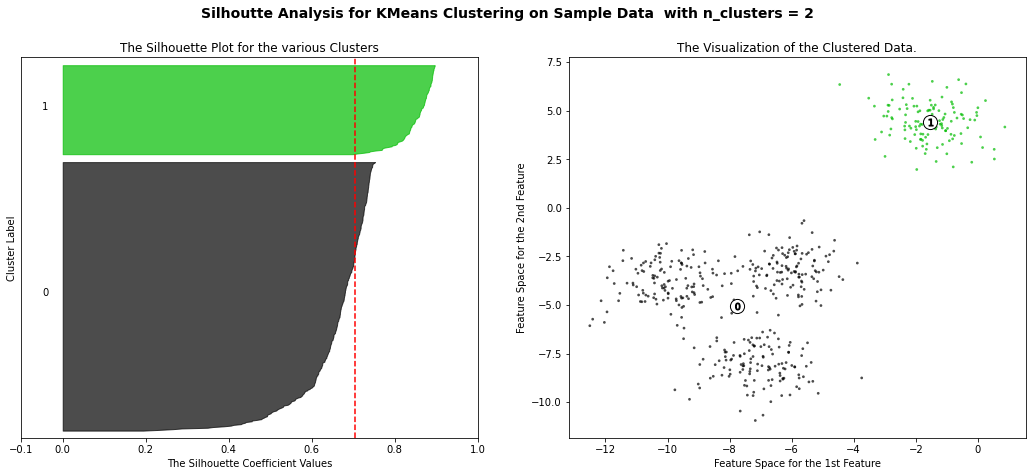

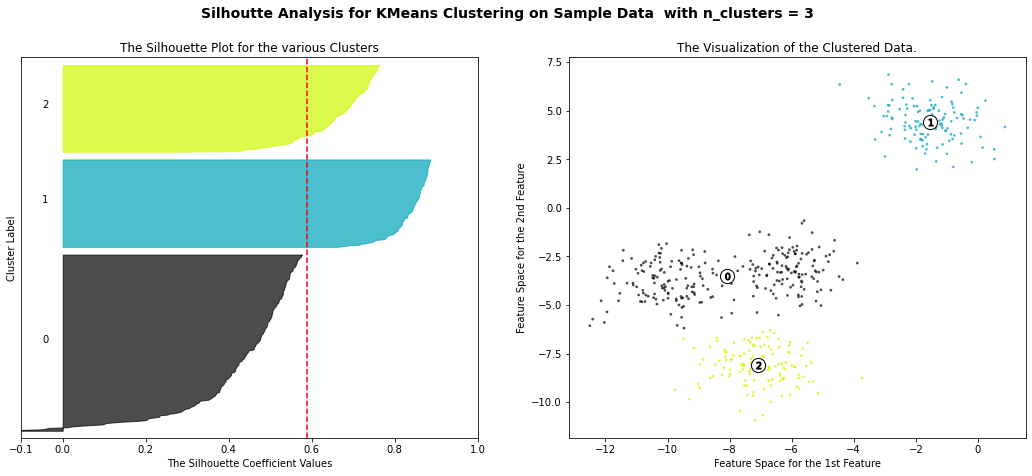

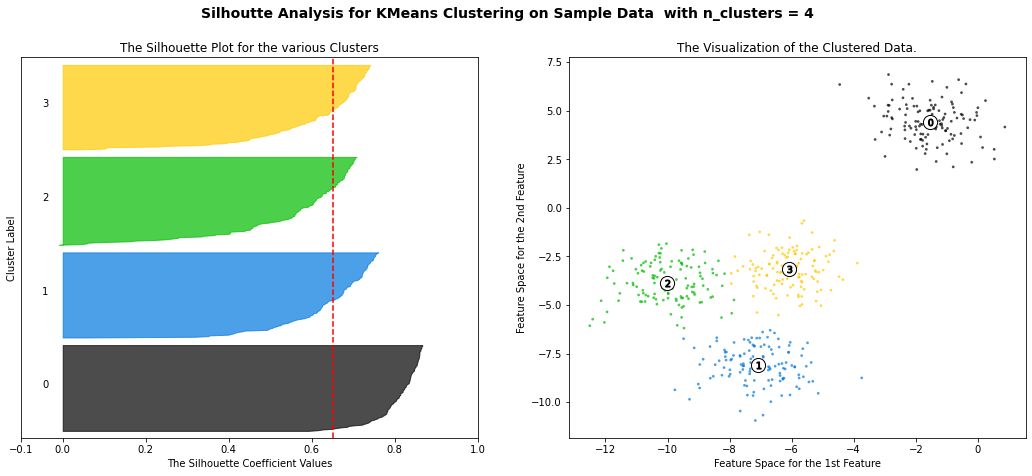

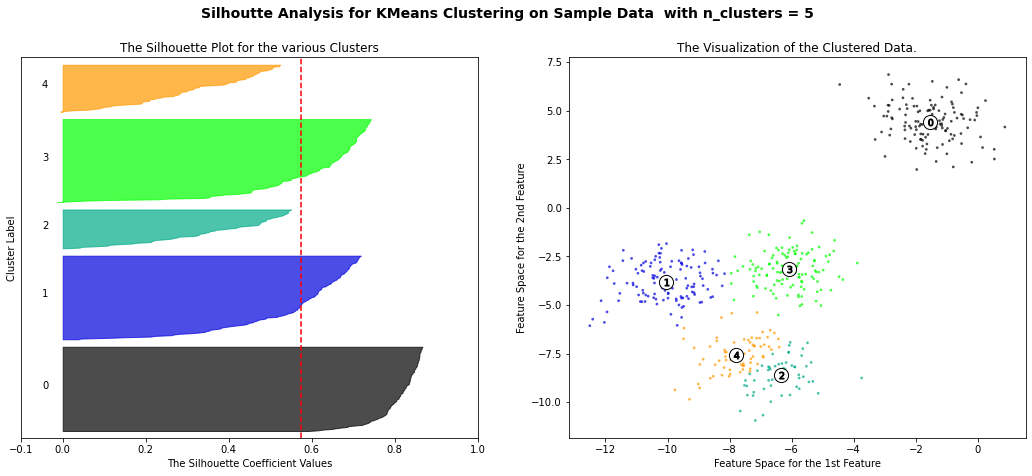

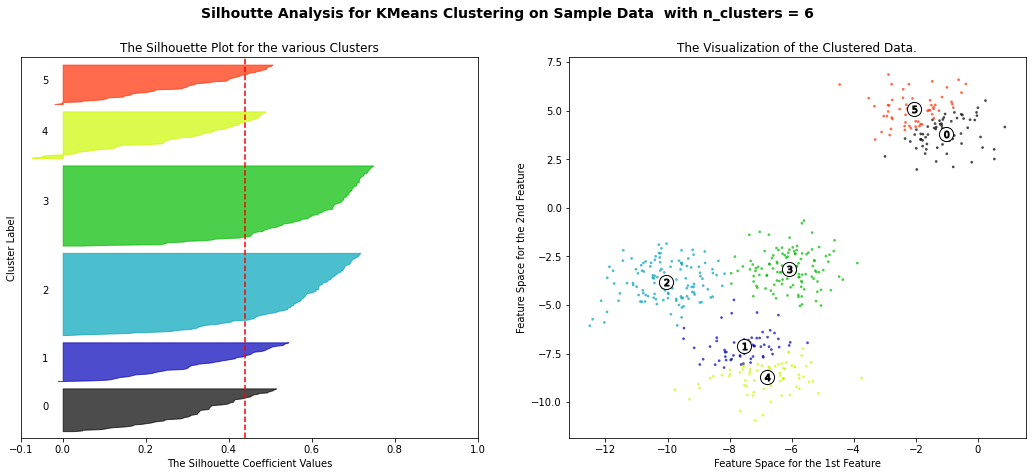

In [24]:
for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Silhouette Plot 
    ax1.set_xlim([-.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1)*10])
    
    # initialize the clusterer with the n_clusters value 
    clusterer = KMeans(n_clusters=n_clusters, random_state = 10)
    cluster_labels = clusterer.fit_predict(X)
    
    # Silhouette_score gives avg value for all samples 
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For N clusters:", n_clusters, ",The Average silhouette score is :", silhouette_avg)
    
    # Get Silhouette Scores for each sample 
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    y_lower = 10
    for i in range(n_clusters):
        
        # Aggregate scores for samples in the ith cluster, and sort 
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, 
                         facecolor = color, edgecolor = color, alpha = 0.7)
        
        # Label the silhouette plots with the cluster number in the middle 
        ax1.text(-0.05, y_lower + 0.5*size_cluster_i, str(i))
        
        # Computer the new y_lower for the next plot 
        y_lower = y_upper + 10 # Without this step, plots are all on top of each other 
        
    ax1.set_title("The Silhouette Plot for the various Clusters")
    ax1.set_xlabel("The Silhouette Coefficient Values")
    ax1.set_ylabel("Cluster Label")
    
    # The Vertical Line for avg. Silhouette Score of all the values 
    ax1.axvline(x = silhouette_avg, color = 'red', linestyle = "--")
    
    ax1.set_yticks([]) # Clear the Y Axis 
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot shows the actual clusters formed 
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker = ".", s=30, lw=0, alpha=0.7,
               c = colors, edgecolor = 'k')

    # Label the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers 
    ax2.scatter(centers[:, 0], centers[:, 1], marker = 'o', 
               c = 'white', alpha = 1, s = 200, edgecolor = 'k')
    
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker = '$%d$' % i, alpha = 1, 
                   s = 50, edgecolor = 'k')
    
    ax2.set_title("The Visualization of the Clustered Data.")
    ax2.set_xlabel("Feature Space for the 1st Feature")
    ax2.set_ylabel("Feature Space for the 2nd Feature")
    
    plt.suptitle(("Silhoutte Analysis for KMeans Clustering on Sample Data "
                    " with n_clusters = %d" %n_clusters),
                fontsize = 14, fontweight = 'bold')
    
    
plt.show()

#### Demo K-Means Clustering with MNIST Digits

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

In [25]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)

X_digits, y_digits = load_digits(return_X_y=True)

data = scale(X_digits)

n_samples, n_features = data.shape
n_digits = len(np.unique(y_digits))
labels = n_digits

sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
     % (n_digits, n_samples, n_features))

print(82 * '_')

print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    
    #print(estimator.inertia_) 
    #print(metrics.homogeneity_score(y_digits, estimator.labels_))
  
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
      % (name, (time() - t0), estimator.inertia_,
         metrics.homogeneity_score(y_digits, estimator.labels_),
         metrics.completeness_score(y_digits, estimator.labels_),
         metrics.v_measure_score(y_digits, estimator.labels_),
         metrics.adjusted_rand_score(y_digits, estimator.labels_),
         metrics.adjusted_mutual_info_score(y_digits,  estimator.labels_),
         metrics.silhouette_score(data, estimator.labels_,
                                  metric='euclidean',
                                  sample_size=sample_size)))
    


bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(82 * '_')


n_digits: 10, 	 n_samples 1797, 	 n_features 64
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.17s	69510	0.610	0.657	0.633	0.481	0.629	0.129
random   	0.16s	69907	0.633	0.674	0.653	0.518	0.649	0.131
PCA-based	0.02s	70768	0.668	0.695	0.681	0.558	0.678	0.142
__________________________________________________________________________________


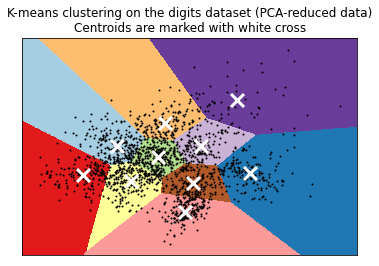

In [26]:
# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

## Step 1

For KMeans, consider these metrics:
- Inertia (TSS): MINIMIZE the Inertia, or the distance from points to their centers. Find the point where adding more clusters does not decrease the inertia, and use this as optimal clusters
- Silhoutte Score: MAXIMIZE the SScore, this shows us how separate clusters are from another 



start = time.time()
tsne = TSNE(n_components = 2, verbose =1, perplexity =40, n_iter=300)
tsne_results = tsne.fit_transform(X_Train_Polling)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-start))

tsne_results = pd.DataFrame(tsne_results)
print(tsne_results.shape)
tsne_results = tsne_results.iloc[:,0:2]

new_df0 = pd.DataFrame()
new_df0 = pd.concat([ X_Train_Polling.reset_index(drop=True), tsne_results.reset_index(drop=True)], axis = 1)
new_df = pd.concat([new_df0.reset_index(drop=True), Y_Train_Polling.reset_index(drop=True)], axis = 1)
print(new_df.shape)
new_df.head()

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Dem_Ind",
    palette=sns.color_palette("hls", 2),
    data=new_df,
    legend="full",
    alpha=0.3
)


In [27]:
from sklearn.manifold import TSNE 
import seaborn as sns
import time 

def make_tsne(X_Data, Y_Data):
    start = time.time()
    tsne = TSNE(n_components = 2, verbose =1, perplexity =40, n_iter=300)
    tsne_results = tsne.fit_transform(X_Data)
    tsne_results = pd.DataFrame(tsne_results, columns = ['tsne-2d-one', 'tsne-2d-two'])
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-start))
    return tsne_results

In [28]:
tsne_results = make_tsne(X_Train_Polling, Y_Train_Polling)

print(tsne_results.head())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7000 samples in 0.079s...
[t-SNE] Computed neighbors for 7000 samples in 6.186s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7000
[t-SNE] Computed conditional probabilities for sample 2000 / 7000
[t-SNE] Computed conditional probabilities for sample 3000 / 7000
[t-SNE] Computed conditional probabilities for sample 4000 / 7000
[t-SNE] Computed conditional probabilities for sample 5000 / 7000
[t-SNE] Computed conditional probabilities for sample 6000 / 7000
[t-SNE] Computed conditional probabilities for sample 7000 / 7000
[t-SNE] Mean sigma: 0.916052
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.771439
[t-SNE] KL divergence after 300 iterations: 3.451939
t-SNE done! Time elapsed: 16.24199104309082 seconds
   tsne-2d-one  tsne-2d-two
0    -8.189381    -0.499679
1    -5.700143    -3.255080
2     4.742919     1.915717
3    -1.524964    -2.915667
4     5.565899    -1.015226


   tsne-2d-one  tsne-2d-two  Dem_Ind
0    -8.189381    -0.499679        1
1    -5.700143    -3.255080        1
2     4.742919     1.915717        0
3    -1.524964    -2.915667        1
4     5.565899    -1.015226        0
Index(['tsne-2d-one', 'tsne-2d-two', 'Dem_Ind'], dtype='object')


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

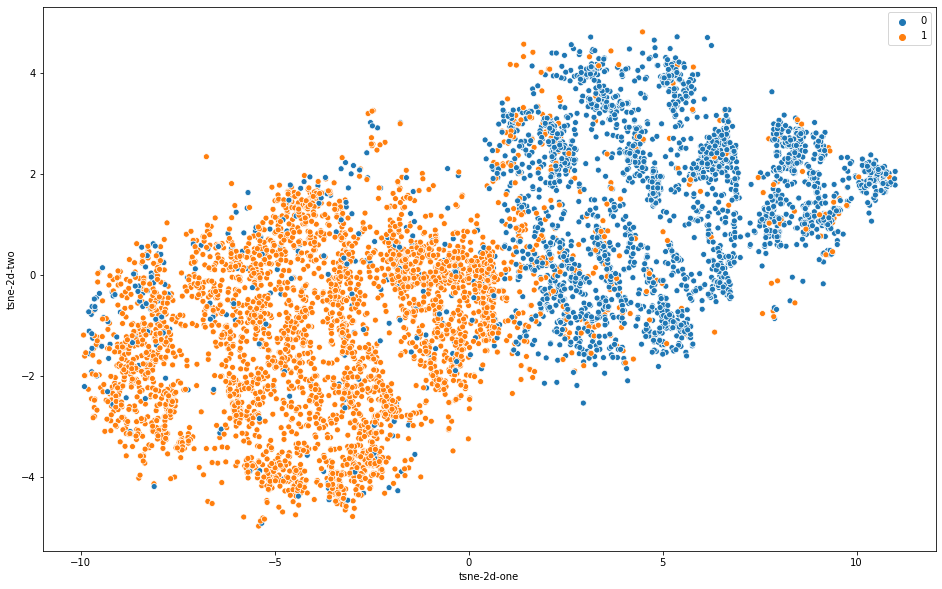

In [29]:
tsne_results.shape
new_df = pd.concat([tsne_results.reset_index(drop=True), Y_Train_Polling.reset_index(drop=True)], axis = 1)

print(new_df.head())
print(new_df.columns)
plt.figure(figsize=(16,10))
sns.scatterplot(data = new_df, x = 'tsne-2d-one', y = 'tsne-2d-two', hue = new_df.Dem_Ind.to_list())


#### KMeans Data 1

In [30]:
import matplotlib.cm as cm

def run_kmeans(X_Data, range_num_clusters, title):
      
    n_clusters_list = []
    inertia_list = []
    avg_silhouette_list = []
    
    for n_clusters in range_num_clusters:
        kmeans_clusterer =  KMeans(n_clusters = n_clusters, init = 'k-means++', n_init = 10, random_state = 42)
        kmeans_cluster_labels = kmeans_clusterer.fit_predict(X_Data)
        kmeans_silhouette_avg = silhouette_score(X_Data, kmeans_cluster_labels)

        
        n_clusters_list.append(n_clusters)
        inertia_list.append(kmeans_clusterer.inertia_)
        avg_silhouette_list.append(kmeans_silhouette_avg)
        
    
    ######
    #plt.clf()
    #plt.plot(n_clusters_list, inertia_list)
    #plt.xlabel("Number of Clusters")
    #plt.ylabel("Inertia")
    #plt.title("The Effect of Number of Clusters \non Inertia for " + title)
    #plt.show()
    
    #plt.clf()
    #plt.plot(n_clusters_list, avg_silhouette_list)
    #plt.xlabel("Number of Clusters")
    #plt.ylabel("Average Silhouette Score")
    #plt.title("The Effect of Number of Clusters \non Silhouette for " + title)
    #plt.show()
    
    ##
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(n_clusters_list, inertia_list, 'blue', label = 'Inertia')
    ax1.set_xlabel('Number of Clusters')
    ax1.plot([], [], 'green', label = 'Silhouette Score')
    ax1.legend()
    ax1.set_ylabel('Inertia')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(n_clusters_list, avg_silhouette_list, 'green', label = 'Silhouette Score')
    ax2.set_ylabel('Avg. Silhouette Score')
    plt.grid(False)

    plt.title("The Effect of Number of Clusters \non Inertia and Avg. Silhouette Score  \n for " + title + " with K-Means")
    
    fig.tight_layout()
    plt.show()
    

#### Data # 1

<Figure size 432x288 with 0 Axes>

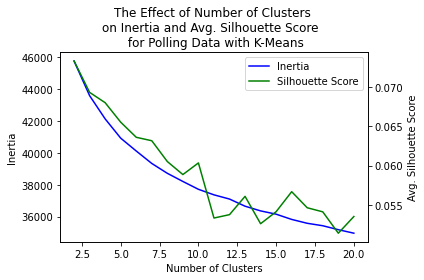

None
325.85654520988464


In [31]:
import time

start = time.time()

labels = run_kmeans(X_Train_Polling, np.arange(2, 21, 1) , "Polling Data")
print(labels)

end = time.time()
elapsed = end-start
print(elapsed)

<Figure size 432x288 with 0 Axes>

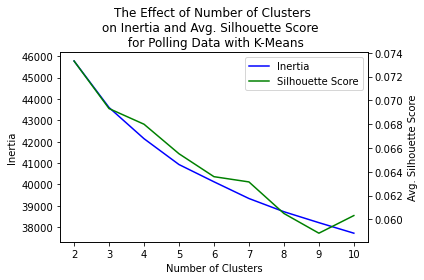

None
9.566987037658691


In [32]:
import time

start = time.time()

labels = run_kmeans(X_Train_Polling, np.arange(2, 11, 1) , "Polling Data")
print(labels)

end = time.time()
elapsed = end-start
print(elapsed)

<Figure size 432x288 with 0 Axes>

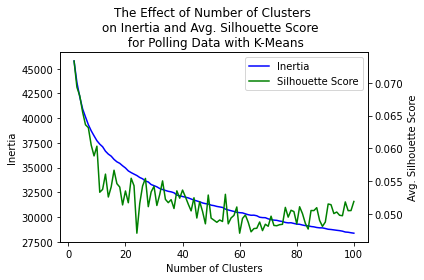

None
792.3788840770721


In [33]:
import time

start = time.time()

labels = run_kmeans(X_Train_Polling, np.arange(2, 101, 1) , "Polling Data")
print(labels)

end = time.time()
elapsed = end-start
print(elapsed)

- KMEANS, Data 1, the elbow appears around 10 clusters

#### KMeans Data 2

#### Data #2

<Figure size 432x288 with 0 Axes>

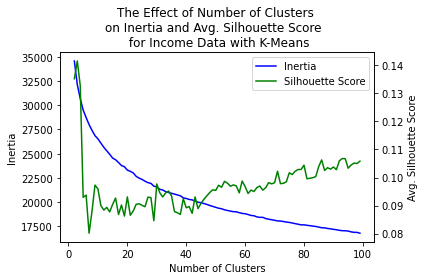

257.9900960922241


In [34]:
start = time.time()

run_kmeans(X_Train_Income, np.arange(2, 100, 1) , "Income Data")

end = time.time()
elapsed = end-start
print(elapsed)

<Figure size 432x288 with 0 Axes>

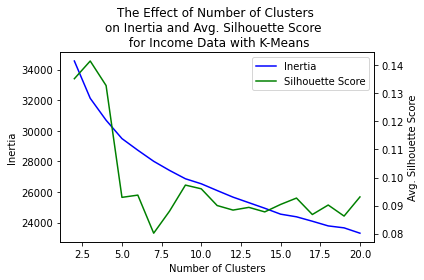

19.088643074035645


In [35]:
start = time.time()

run_kmeans(X_Train_Income, np.arange(2, 21, 1) , "Income Data")

end = time.time()
elapsed = end-start
print(elapsed)

- KMEANS, Data 2, the best result seems around 8 clusters

### EM Data 1

In [36]:
from sklearn.mixture import GaussianMixture as EM

def run_em(X_Data, k_list, title, cov_type):
    
    aic_list = []
    bic_list = []
    avg_silhouette_list = []
    n_components_list = []
    
    for k in k_list:
        em = EM(n_components = k, covariance_type = cov_type, n_init = 1, init_params = 'kmeans', random_state = 42)
        em_labels = em.fit_predict(X_Data)
        
        n_components_list.append(k)
        avg_silhouette_list.append(silhouette_score(X_Data, em_labels))
        aic_list.append(em.aic(X_Data))
        bic_list.append(em.bic(X_Data))
        
    #plt.clf()
    #plt.plot(n_components_list, aic_list, label = 'AIC')
    #plt.plot(n_components_list, bic_list, label = 'BIC')
    #plt.legend()
    #plt.xlabel("Number of Components")
    #plt.ylabel("Metric Value")
    #plt.title("The Effect of the Number of Components \non AIC/BIC for " + title + "\n With " + cov_type + " Covariance")
    #plt.show()
    
    #print("Silhouettes", avg_silhouette_list)
    
    #plt.clf()
    #plt.plot(n_components_list, avg_silhouette_list)
    #plt.xlabel("Number of Components")
    #plt.ylabel("Average Silhouette Score")
    #plt.title("The Effect of Number of Components \non Silhouette for " + title + "\n With " + cov_type + " Covariance")
    #plt.show()
    
    ## 
    #plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(n_components_list, aic_list, 'blue', label = 'AIC')
    ax1.plot(n_components_list, bic_list, 'green', label = 'BIC')
    ax1.set_xlabel('Number of Components')
    ax1.plot([], [], 'orange', label = 'Silhouette Score')
    ax1.legend()
    ax1.set_ylabel('AIC/BIC Curves')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(n_components_list, avg_silhouette_list, 'orange', label = 'Silhouette Score')
    ax2.set_ylabel('Avg. Silhouette Score')
    plt.grid(False)

    plt.title("The Effect of Number of Components \non BIC/AIC and Avg. Silhouette Score  \nfor " + title + " with EM, "+ cov_type+" Covariance")
    
    fig.tight_layout()
    plt.show()
    
    
        
    

Covariance type: full


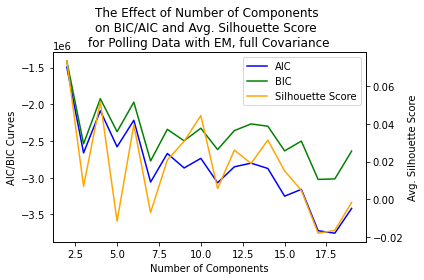

Covariance type: tied


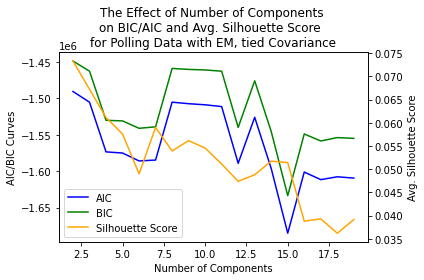

Covariance type: diag


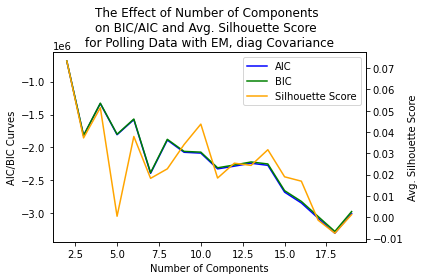

Covariance type: spherical


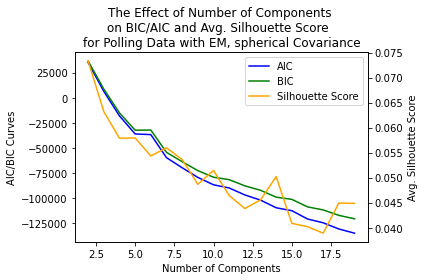

In [37]:
covariance_type = ['full', 'tied', 'diag', 'spherical']

for cv in covariance_type:
    print("Covariance type:", cv)
    run_em(X_Train_Polling, np.arange(2, 20, 1), "Polling Data", cv)

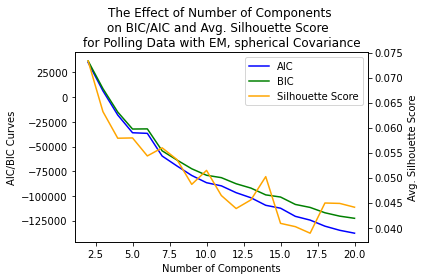

In [38]:
run_em(X_Train_Polling, np.arange(2, 21, 1), "Polling Data", 'spherical')

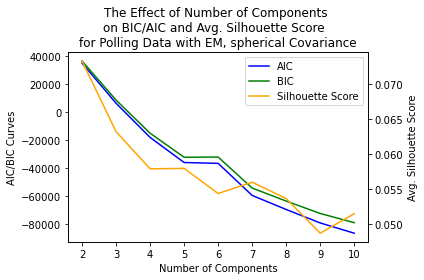

In [39]:
run_em(X_Train_Polling, np.arange(2, 11, 1), "Polling Data", 'spherical')

Data 1:
- Silhouette Max score occurs for n_components = 2, for all cov_types, at 0.0733
- Highest Silhouette occurs for covariance type = Spherical, highest floor of 0.449 
- BIC/AIC elbow method occurs for n_components = 5, for Spherical, or 3 for others 

#### EM Data #2

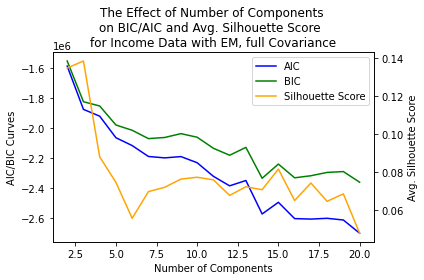

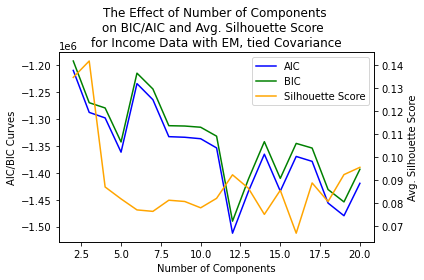

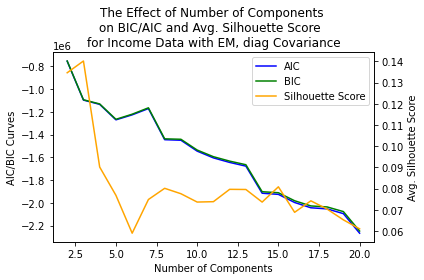

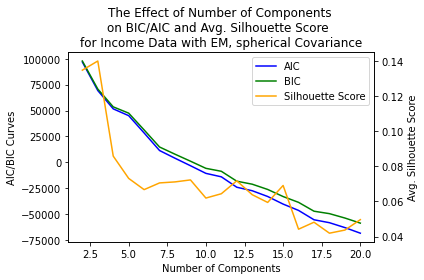

In [40]:
covariance_type = ['full', 'tied', 'diag', 'spherical']

for cv in covariance_type:
    run_em(X_Train_Income, np.arange(2, 21, 1), "Income Data", cv)

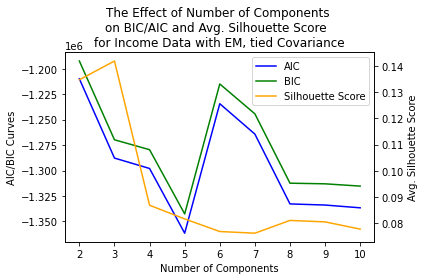

In [41]:
run_em(X_Train_Income, np.arange(2, 11, 1), "Income Data", 'tied')

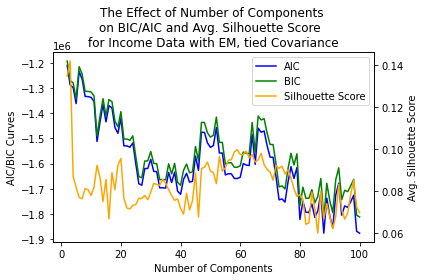

In [42]:
run_em(X_Train_Income, np.arange(2, 101, 1), "Income Data", 'tied')

Data 2:
- Silhouette Max score occurs for n_components = 3 at 0.142
- Highest Silhouette occurs for covariance type = 'tied'
- BIC/AIC elbow method occurs for n_components = 5, heuristic method shows where decrease slows down

## Step 2) Apply Dimensionality Reduction Algorithms to the Datasets

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

Implement 4 Dimensionality Reduction Algorithms on the 2 Data sets
- PCA: Principal Components Analysis
- ICA: Independent Components Analysis
- RCA: Random Components Analysis 
- RFC: Random Forest Classifier

https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues

### 2.1) PCA 

In [43]:
def pca_chart_kmeans(X_Data, Optimal_Num_Clusters, title):
    # From SKLearn example: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

    reduced_data = PCA(n_components=2).fit_transform(X_Data)
    kmeans = KMeans(init='k-means++', n_clusters=Optimal_Num_Clusters, n_init=10)
    kmeans.fit(reduced_data)
    
    ###
    plt.clf()
    x = reduced_data[:, 0]
    y = reduced_data[:, 1]
    plt.scatter(x, y, color = 'k')
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:,1], marker = 'X', color = 'white')
    
    plt.show()
    
    ###
    h = 0.02

    x_min, x_max = reduced_data[:,0].min()-0.25, reduced_data[:,0].max() +0.25
    y_min, y_max = reduced_data[:,1].min()-0.25, reduced_data[:,1].max() +0.25
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='w', zorder=10)
    plt.title("K-Means Clustering on Top 2 PCA Dimensions \nfor " + title)


    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

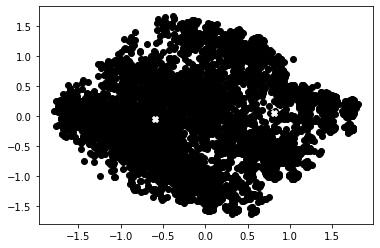

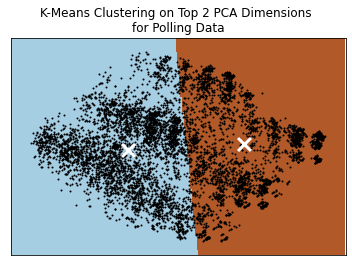

In [44]:
pca_chart_kmeans(X_Train_Polling, 2, "Polling Data")

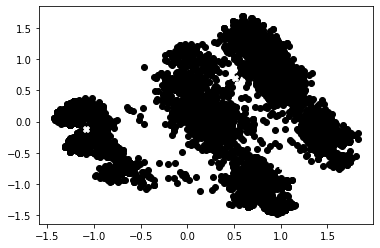

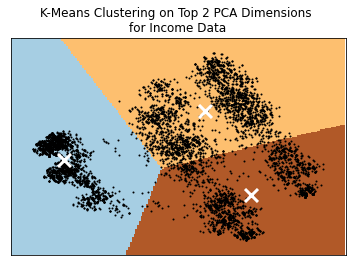

In [45]:
pca_chart_kmeans(X_Train_Income, 3, "Income Data")

In [46]:
from sklearn.decomposition import PCA 

# No need to use Standard Scaler because we are using Binary Variables 

def run_PCA(X_Data, title):
    
    #pca = PCA(n_components = .80, random_state = 42)
    pca = PCA(random_state = 42)
    pca.fit(X_Data)

    pca80 = PCA(n_components = 0.80, random_state = 42)
    pca80.fit(X_Data)
    print("Optimal Number of Components:", pca80.n_components_)
    max_feats = X_Data.shape[1]
    
    recon_error_list = []
    for i in range(2, max_feats):
        pca = PCA(n_components = i, random_state =42)
        pca.fit(X_Data)
        
        X_Trans =  pca.transform(X_Data)
        X_Proj = pca.inverse_transform(X_Trans)
        Error_Recon = metrics.mean_squared_error(X_Data, X_Proj)
        recon_error_list.append(Error_Recon)
    
    #plt.clf()
    x = np.arange(1, pca.n_components_ +1)
    y1 = pca.explained_variance_ratio_.cumsum()
    #plt.plot(x, y1)
    #plt.plot(x, np.repeat(0.8, pca.n_components_), linestyle = '--', color = 'red')
    #plt.ylabel("Cumulative Explained Variance")
    #plt.xlabel("Number of Components")
    #plt.title("The Effect of Number of Components \non Cumulative Explained Variance \nfor "+ title)
    #plt.show()
    
    plt.clf()
    plt.plot(recon_error_list)
    plt.xlabel("Number of Components")
    plt.show()
    
    y2 = pca.singular_values_
    #plt.clf()
    #plt.plot(x, y2)
    #plt.xlabel("Number of Components")
    #plt.ylabel("Eigenvalues")
    #plt.title("The Effect of the Number of Components \non Eigenvalues for " + title)
    #plt.show()
    
    # 
    fig, ax1 = plt.subplots()
    ax1.plot(x, y1, 'blue', label = 'Cumulative Explained Variance')
    ax1.plot(x, np.repeat(0.8, pca.n_components_), linestyle = '--', color = 'red')
    ax1.set_xlabel('Number of Components')
    ax1.plot([], [], 'green', label = 'Eigenvalues')
    ax1.legend()
    ax1.set_ylabel('Cumulative Explained Variance')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(x, y2, 'green')
    ax2.set_ylabel('Eigenvalues')
    plt.grid(False)
    plt.title("The Effect of Number of Components \non Explained Variance and Eigenvalues\nfor " + title + " with PCA")
    fig.tight_layout()
    plt.show()

Optimal Number of Components: 31


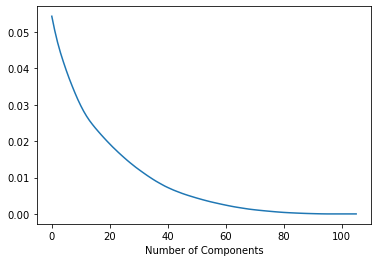

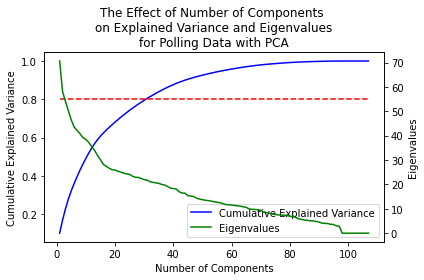

In [47]:
run_PCA(X_Train_Polling, "Polling Data")

In [48]:
X_Train_Polling.shape

(7000, 108)

Data #1
- Optimal Number of Components is 31

Optimal Number of Components: 19


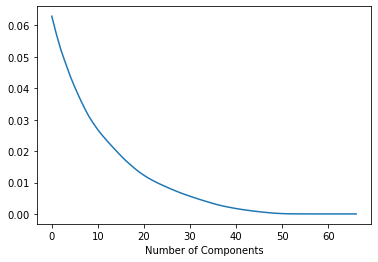

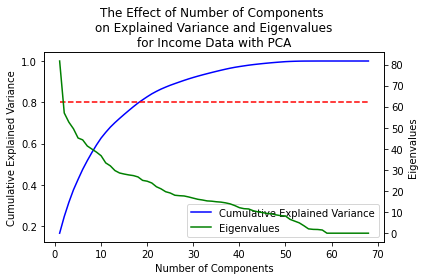

3.9929428100585938


In [49]:
start = time.time()

run_PCA(X_Train_Income, "Income Data")

end = time.time()
elapsed = end-start
print(elapsed)

Data #2
- Optimal Number of Components is 19
- Higher values of Eigenvalues is better, where n_components is 2 

In [135]:
def compare_recon_error(X_Data, title):

    max_feats = X_Data.shape[1]

    pca_recon_error_list = []
    ica_recon_error_list = []
    rca_recon_error_list = []
    pca_time_list = []
    ica_time_list = []
    rca_time_list = []
    
    for num in range(2, max_feats):
        #print("N Components: ", num)
        start_pca = time.time()
        pca = PCA(n_components = num, random_state =42)
        pca.fit(X_Data)

        X_Trans =  pca.transform(X_Data)
        X_Proj = pca.inverse_transform(X_Trans)
        Error_Recon = metrics.mean_squared_error(X_Data, X_Proj)
        pca_recon_error_list.append(Error_Recon)
        #print("PCA:", Error_Recon)
        end_pca = time.time()
        pca_time_list.append(end_pca-start_pca)
        
        start_ica = time.time()
        ica = ICA(random_state=42)
        ica.set_params(n_components=num)
        X_Transformed = ica.fit_transform(X_Data)
        X_Proj = ica.inverse_transform(X_Transformed)
        Error_Recon = metrics.mean_squared_error(X_Data, X_Proj)
        ica_recon_error_list.append(Error_Recon)
        #print("ICA:", Error_Recon)
        end_ica = time.time()
        ica_time_list.append(end_ica-start_ica)
        
        start_rca = time.time()
        rca = GRP(n_components=num, random_state = 42)
        X_Reduced = rca.fit_transform(X_Data)
        psuedo_inverse = np.linalg.pinv(rca.components_.T)
        X_Reconstructed = X_Reduced.dot(psuedo_inverse)
        Error_Recon = metrics.mean_squared_error(X_Data, X_Reconstructed)
        rca_recon_error_list.append(Error_Recon)
        #print("RCA:", Error_Recon)
        end_rca = time.time()
        rca_time_list.append(end_rca-start_rca)
        
    plt.clf()
    plt.plot(pca_recon_error_list, label = "PCA")
    plt.plot(ica_recon_error_list, label = "ICA")
    plt.plot(rca_recon_error_list, label = "RCA")
    plt.xlabel("Number of Components")
    plt.ylabel("Reconstruction Error")
    plt.title("Comparing The Effect of Number of Components \non Reconstruction Error for \n PCA, ICA, RCA with " + title)
    plt.legend()
    plt.show()
    
    plt.clf()
    plt.plot(pca_time_list, label = "PCA")
    plt.plot(ica_time_list, label = "ICA")
    plt.plot(rca_time_list, label = "RCA")
    plt.xlabel("Number of Components")
    plt.ylabel("Time (Sec)")
    plt.title("Comparing The Effect of Number of Components \non RunTime for \n PCA, ICA, RCA with " + title)
    plt.legend()
    plt.show()
    
    print("PCA last Error:",pca_recon_error_list[-1])
    print("ICA last Error:",ica_recon_error_list[-1])
    print("RCA last Error:",rca_recon_error_list[-1])
    
    print("PCA max time:",pca_time_list[-1])
    print("ICA max time:",ica_time_list[-1])
    print("RCA max time:",rca_time_list[-1])
    
    
    

In [ ]:
compare_recon_error(X_Train_Polling, "Polling Data")

In [ ]:
compare_recon_error(X_Train_Income, "Income Data")

### 2.2) ICA

In [82]:
from sklearn.decomposition import FastICA as ICA 

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

def run_ICA(X_Data, title):
    
    max_feats = X_Data.shape[1]
    
    n_components_list = np.arange(2, max_feats, 1)
    #n_components_list = np.arange(2, 10, 1)
    
    ica = ICA(random_state=42)
    kurtosis_list = []
    recon_error_list = []

    for num in n_components_list:
        ica.set_params(n_components=num)
        X_Transformed = ica.fit_transform(X_Data)
        X_Transformed_df = pd.DataFrame(X_Transformed)
        # Find the Kurtosis Over Requested Acxis, where 0 means find Kurtosis over rows 
        X_Transformed_Kurtosis = X_Transformed_df.kurt(axis=0) # Returns Series 
        avg_kurtosis = X_Transformed_Kurtosis.abs().mean()
        kurtosis_list.append(avg_kurtosis)
        
        X_Proj = ica.inverse_transform(X_Transformed)
        Error_Recon = metrics.mean_squared_error(X_Data, X_Proj)
        recon_error_list.append(Error_Recon)
        
        print("N components:",num)
        print("Kurtosis:", avg_kurtosis)
        print("Recon error:", Error_Recon)
       
    #
    plt.clf()
    plt.plot(recon_error_list)
    plt.xlabel("Number of Components")
    plt.show()
    
    maxElement = np.amax(kurtosis_list)
    result = np.where(kurtosis_list == np.amax(kurtosis_list))
    print("Max Value:",maxElement)
    print("N Components:",result[0][0] +2)
    
    plt.figure()
    plt.title("The Effect of the Indepdent Components \non The Average Kurtosis \nfor "+ title)
    plt.xlabel("Number of Independent Components")
    plt.ylabel("Avg Kurtosis Across IC")
    plt.plot(n_components_list, kurtosis_list)
    plt.grid(False)
    plt.show()
    
    # 
    fig, ax1 = plt.subplots()
    ax1.plot(n_components_list, kurtosis_list, 'blue', label = 'Kurtosis')
    ax1.set_xlabel('Number of Components')
    ax1.plot([], [], 'green', label = 'Reconstruction Error')
    ax1.legend()
    ax1.set_ylabel('Kurtosis')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(n_components_list, recon_error_list, 'green')
    ax2.set_ylabel('Reconstruction Error')
    plt.grid(False)
    plt.title("The Effect of Number of Components \non Kurtosis and Reconstruction Error\nfor " + title + " with ICA")
    fig.tight_layout()
    plt.show()
    
    

N components: 2
Kurtosis: 1.131709511472693
Recon error: 0.054317694943711456
N components: 3
Kurtosis: 1.2547155182090055
Recon error: 0.050453396339340366
N components: 4
Kurtosis: 1.2275060076570872
Recon error: 0.047124586712663
N components: 5
Kurtosis: 1.3172585392254257
Recon error: 0.04427630790328286
N components: 6
Kurtosis: 1.2139412570176151
Recon error: 0.041772850648094245
N components: 7
Kurtosis: 1.2021009447346311
Recon error: 0.03942207436285466
N components: 8
Kurtosis: 1.2576556973485638
Recon error: 0.03722381519888906
N components: 9
Kurtosis: 1.2243427852312512
Recon error: 0.035193239050967814
N components: 10
Kurtosis: 1.235041043470498
Recon error: 0.033236628702371734
N components: 11
Kurtosis: 1.2594495065390066
Recon error: 0.0314020168860219
N components: 12
Kurtosis: 1.2604807076389686
Recon error: 0.02972851399163817
N components: 13
Kurtosis: 1.3505790958495951
Recon error: 0.028203446716442666
N components: 14
Kurtosis: 1.401025370273739
Recon error: 0

N components: 106
Kurtosis: 69.43767385803189
Recon error: 0.06537644822373492
N components: 107
Kurtosis: 67.06691592491667
Recon error: 0.06537644822373492


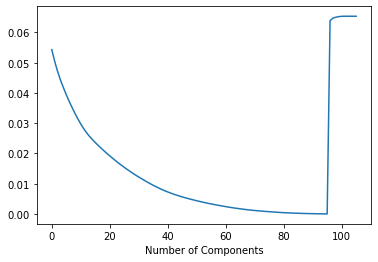

Max Value: 94.94879791206175
N Components: 98


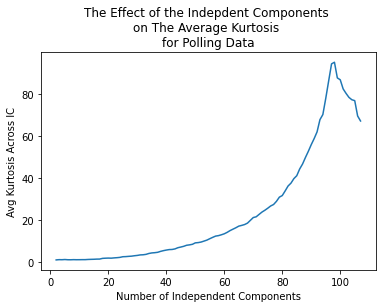

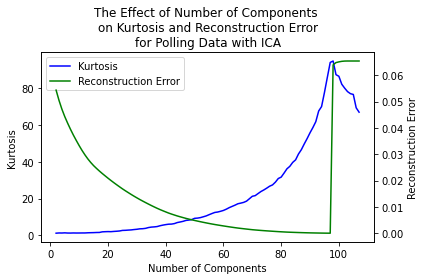

111.20642828941345


In [83]:
start = time.time()

run_ICA(X_Train_Polling, "Polling Data")

end = time.time()
elapsed = end-start
print(elapsed)

PICK N = 97 for low error and high Kurtosis 

- N components: 97
- Kurtosis: 94.17773130302514
- Recon error: 4.858697723345357e-31
- N components: 98
- Kurtosis: 94.94879791206175
- Recon error: 0.06391708974998132

- When number of IC components = 30, that is when Kurtosis > 3
- Kurtosis = 3 when a distribution is Normally Distributed
- Kurtosis >> 3 implies that there is a lot of weight in the tails of a distribution, measures many outliers
- ICA did not converge, even with 2000 max iterations, but values did not change by increasing 
- We want the highest absolute value of Kurtosis, this implies the most Non-Gaussian

N components: 2
Kurtosis: 0.8101149071454676
Recon error: 0.0629465785051288
N components: 3
Kurtosis: 1.2238968784507718
Recon error: 0.057206247626632206
N components: 4
Kurtosis: 1.1836139718774663
Recon error: 0.052129579225810775
N components: 5
Kurtosis: 1.1853864281489916
Recon error: 0.04791193234510191
N components: 6
Kurtosis: 1.074620730640124
Recon error: 0.043855961749134025
N components: 7
Kurtosis: 1.1974117932963073
Recon error: 0.040314492580241716
N components: 8
Kurtosis: 1.3316357883983336
Recon error: 0.03702096590610343
N components: 9
Kurtosis: 1.229118255214117
Recon error: 0.03396261672107488
N components: 10
Kurtosis: 1.1731913545482582
Recon error: 0.031169889765369007
N components: 11
Kurtosis: 1.5030991859542049
Recon error: 0.02886940976813228
N components: 12
Kurtosis: 1.6770425962501212
Recon error: 0.026758190417010254
N components: 13
Kurtosis: 1.6502353793976128
Recon error: 0.02493174493328907
N components: 14
Kurtosis: 1.6141219504239088
Recon error

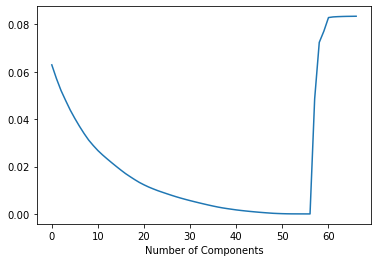

Max Value: 244.32727740295124
N Components: 61


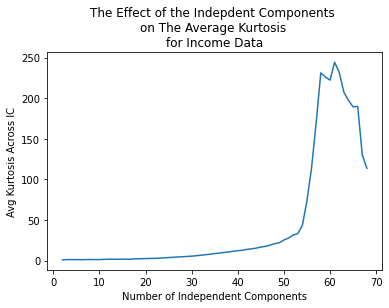

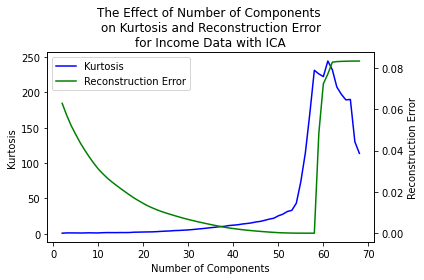

35.0909161567688


In [84]:
start = time.time()

run_ICA(X_Train_Income, "Income Data")

end = time.time()
elapsed = end-start
print(elapsed)

PICK N = 58 for low Recon Error and high Kurtosis 

- N components: 58
- Kurtosis: 231.2040757032121
- Recon error: 3.36867344348749e-30
- N components: 59
- Kurtosis: 226.09335304054173
- Recon error: 0.04852882560375692
- N : 60
- Kurtosis: 222.29184308580062
- Recon error: 0.07244750864782903
- N components: 61
- Kurtosis: 244.32727740295124
- Recon error: 0.07718772839575531

- Kurtosis stays much lower in this dataset through around 55 independent components, but then it shoots up over 200 kurtosis, which is much higher than Dataset 1 
- When number of IC equals 24, the Kurtosis Exceeds a value of 3

### 2.3) RCA 

In [54]:
from sklearn.random_projection import GaussianRandomProjection as GRP

def run_RCA(X_Data, title):
    
    max_feats = X_Data.shape[1]
    n_components_list = np.arange(2, max_feats, 1)
    #n_components_list = np.arange(40, 55, 1)
    
    restarts = np.arange(1, 6, 1)
    list_of_lists = []
    
    for iteration in restarts:
        iterlist = []
        
        for num in n_components_list:

            rpa = GRP(n_components=num, random_state = iteration)

            # Fit to data using on n components 
            X_Reduced = rpa.fit_transform(X_Data)

            # Pseudo Inverse 
            psuedo_inverse = np.linalg.pinv(rpa.components_.T)
            X_Reconstructed = X_Reduced.dot(psuedo_inverse)

            Error_Recon = metrics.mean_squared_error(X_Data, X_Reconstructed)
            iterlist.append(Error_Recon)
            
        list_of_lists.append(iterlist)

    # Plot 1 
    y1 = list_of_lists[0]
    y2 = list_of_lists[1]
    y3 = list_of_lists[2]
    y4 = list_of_lists[1]
    y5 = list_of_lists[2]
    
    plt.plot(n_components_list, y1)
    plt.plot(n_components_list, y2)
    plt.plot(n_components_list, y3)
    plt.plot(n_components_list, y4)
    plt.plot(n_components_list, y5)
    
    plt.ylabel("Reconstruction Error")
    plt.xlabel("Number of Random Components")
    plt.title("The Effect of Number of Random Components \nOn The Reconstruction Error \nfor " + title)
    plt.show()
    
    # Combine Plots Added 10.29.2020
    rca_df =  pd.DataFrame(zip(n_components_list, y1, y2, y3, y4, y5), columns = ["N Components",'Iter1', 'Iter2', 'Iter3', 'Iter4', 'Iter5'])
    
    rca_df['Mean_Error'] = rca_df.iloc[:, 1:6].mean(axis=1)
    rca_df['STD_Error'] = rca_df.iloc[:, 1:6].std(axis=1)
    
    #print(rca_df)
    
    plt.clf()
    plt.plot(n_components_list, rca_df['Mean_Error'], label = 'Mean Error')
    plt.plot(n_components_list, rca_df['STD_Error'], label = 'STD Error')
    plt.plot(n_components_list, np.repeat(0.05, len(n_components_list)), linestyle = "--", color = 'red')
    plt.legend()
    plt.ylabel("Reconstruction Error")
    plt.xlabel("Number of Random Components")
    plt.title("The Effect of Random Components \non Mean and STD Reconstruction Error on " + title)
    plt.show()
    
    # Modify Code 
    fig, ax1 = plt.subplots()
    ax1.plot(n_components_list, rca_df['Mean_Error'], 'blue', label = 'Mean Error')
    ax1.plot(n_components_list, np.repeat(0.05, len(n_components_list)), linestyle = "--", color = 'red', label = 'Threshold')
    ax1.set_xlabel('Random Components')
    ax1.plot([], [], 'green', label = 'STD Error')
    ax1.legend()
    
    # Make the y-axis label, ticks and tick labels match the line color.
    #ax1.set_ylabel('Mean Reconstruction Error', color='blue')
    ax1.set_ylabel('Mean Reconstruction Error')
    #ax1.tick_params('y', colors='blue')
    plt.grid(False)

    ax2 = ax1.twinx()
    #ax2.plot(n_components_list, rca_df['STD_Error'], 'green', label = 'STD Error')
    ax2.plot(n_components_list, rca_df['STD_Error'], 'green')
    #ax2.set_ylabel('STD Reconstruction Error', color='green')
    #ax2.tick_params('y', colors='green')
    ax2.set_ylabel('STD Reconstruction Error')
    plt.grid(False)

    plt.title("The Effect of Random Components \non Mean and STD Reconstruction Error \nWith 5 Random Restarts on " + title)
    
    fig.tight_layout()
    plt.show()
    

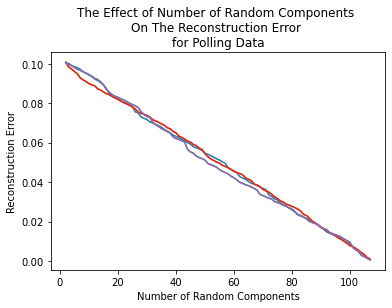

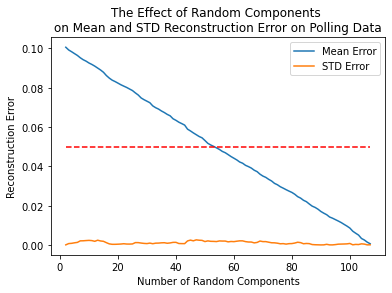

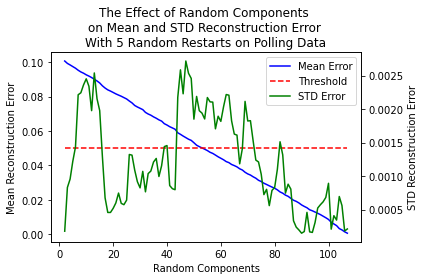

7.646842002868652


In [55]:
start = time.time()

run_RCA(X_Train_Polling, "Polling Data")

end = time.time()
elapsed = end - start
print(elapsed)

- For Data #1, Reconstruction Error is minimized with maximum number of features included
- We can reach less than 5% error rate with 54 number of components 

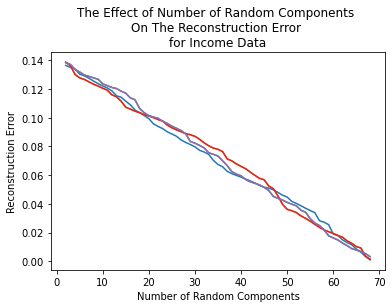

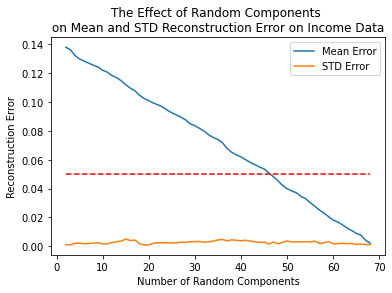

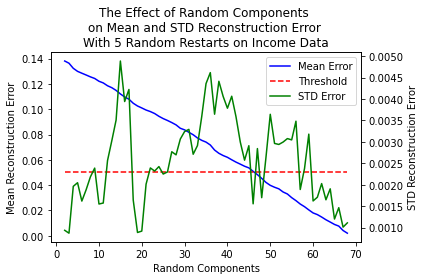

4.250942945480347


In [56]:
start = time.time()

run_RCA(X_Train_Income, "Income Data")

end = time.time()
elapsed = end - start
print(elapsed)

- RCA, Data #2 Requires 47 components

### Step 2.4) Random Forest Classifier

We can use Y in this Dimensionality Reduction Algorithm

In [87]:
from sklearn.ensemble import RandomForestClassifier as RFC

# How many features do we need to get 95% of feature importance? 
def RFC_min_samples_leaf(X_Data, Y_Data, title):
    
    # The Data is 7000 rows long, 70 is 1% of that 
    num_samples_leaf = np.arange(2, 72, 1)
    num_components_list = []
    
    for num in num_samples_leaf:
    
        rfc = RFC(n_estimators=100, min_samples_leaf= num, random_state=42)
        importances = rfc.fit(X_Data, Y_Data).feature_importances_ 

        importances = pd.DataFrame(importances,columns=['Feature Importance'],index=X_Data.columns)
        importances.sort_values(by=['Feature Importance'],inplace=True,ascending=False)
        importances['Cum Sum'] = importances['Feature Importance'].cumsum()
        importances = importances[importances['Cum Sum']<=0.95]
        top_cols = importances.index.tolist()

        #return (importances, top_cols)
        num_components_list.append(len(top_cols))
        
    plt.plot(num_samples_leaf, num_components_list)
    plt.xlabel("Number of Min Leaf Samples")
    plt.ylabel("Number of Components to get 95%")
    plt.title("The Effect of Min Leaf Samples Size \nOn Number of Components in Random Forest \nFor "+ title)
    plt.show()
    

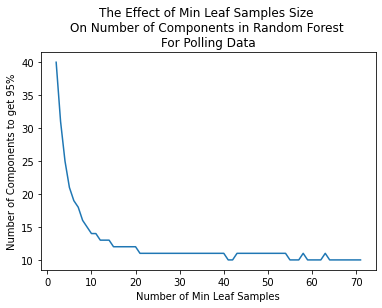

29.651581287384033


In [88]:
start = time.time()

RFC_min_samples_leaf(X_Train_Polling, Y_Train_Polling, "Polling Data")

end = time.time()
elapsed = end-start
print(elapsed)

- Data # 1 should have 12 as the min_samples_leaf size

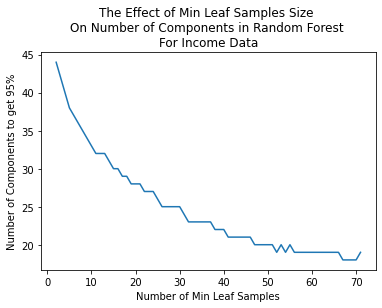

24.897008180618286


In [89]:
start = time.time()

RFC_min_samples_leaf(X_Train_Income, Y_Train_Income, "Income Data")

end = time.time()
elapsed = end-start
print(elapsed)

- Data #2 should have ~47 as the min_samples_leaf size 

In [90]:
from sklearn.ensemble import RandomForestClassifier as RFC

# How many features do we need to get 95% of feature importance? 
def run_RFC(X_Data, Y_Data, min_samples):
    
    rfc = RFC(n_estimators=100, min_samples_leaf=min_samples, random_state=42)
    
    importances = rfc.fit(X_Data, Y_Data).feature_importances_ 
    
    importances = pd.DataFrame(importances,columns=['Feature Importance'],index=X_Data.columns)
    importances.sort_values(by=['Feature Importance'],inplace=True,ascending=False)
    importances['Cum Sum'] = importances['Feature Importance'].cumsum()
    importances = importances[importances['Cum Sum']<=0.95]
    top_cols = importances.index.tolist()
    
    return (importances, top_cols)

In [91]:
importances, top_cols = run_RFC(X_Train_Polling, Y_Train_Polling, 12)

print(importances.shape)

importances

(13, 2)


,Feature Importance,Cum Sum
approval_pres_Strongly Disapprove,0.397137,0.397137
approval_pres_Strongly Approve,0.187498,0.584635
economy_retro_Gotten Much Better,0.105779,0.690414
approval_pres_Approve / Somewhat Approve,0.082038,0.772452
economy_retro_Stayed About The Same,0.035982,0.808434
economy_retro_Gotten Worse / Somewhat Worse,0.031179,0.839612
economy_retro_Gotten Better / Somewhat Better,0.026024,0.865636
race_Black,0.025846,0.891483
race_White,0.018611,0.910093
approval_pres_Disapprove / Somewhat Disapprove,0.013091,0.923185


- Dataset #1 Only requires 13 features to explain 95% of the results, using Random Forest Classifer 

In [92]:
importances, top_cols  = run_RFC(X_Train_Income, Y_Train_Income, 47)

print(importances.shape)

importances

(20, 2)


,Feature Importance,Cum Sum
marital.status_Married-civ-spouse,0.222067,0.222067
relationship_Husband,0.157912,0.379979
age_band_Young,0.071949,0.451929
marital.status_Never-married,0.060349,0.512278
occupation_Exec-managerial,0.054112,0.566390
hours_band_High,0.053364,0.619754
education_Bachelors,0.043697,0.663451
occupation_Prof-specialty,0.042281,0.705732
hours_band_Low,0.031157,0.736889
sex_Female,0.026713,0.763602


- Dataset #2, only Needs 19 components to get 95% of the feature importance using Random Forest Classifier

## Step 3)

#### Step 3) Data 1 

In [93]:
pca_X_Train_Polling = PCA(n_components = 31, random_state = 42).fit_transform(X_Train_Polling)
ica_X_Train_Polling = ICA(n_components = 97, random_state = 42).fit_transform(X_Train_Polling)
rca_X_Train_Polling = GRP(n_components = 54, random_state = 42).fit_transform(X_Train_Polling)

In [94]:
top_cols_df, top_cols = run_RFC(X_Train_Polling, Y_Train_Polling, 12)
rfc_X_Train_Polling = X_Train_Polling[top_cols] 

### Step 3) Data 1 With K-Means

Step 3.1) Data 1 With K-Means with PCA 

<Figure size 432x288 with 0 Axes>

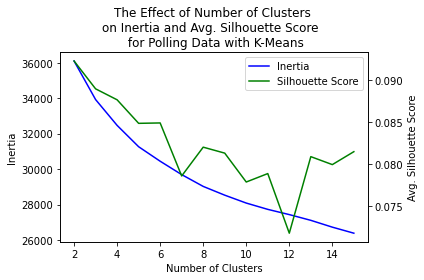

15.548478841781616


In [95]:
start = time.time()

run_kmeans(pca_X_Train_Polling, np.arange(2, 16, 1), "Polling Data")

end = time.time()
elapsed = end - start
print(elapsed)

Step 3.2) Data 1 With K-Means with ICA

<Figure size 432x288 with 0 Axes>

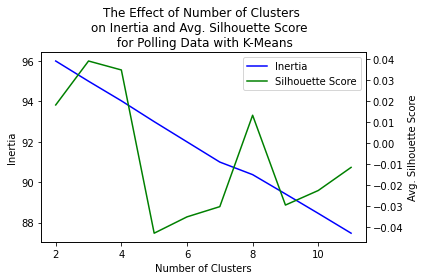

10.301958084106445


In [96]:
start = time.time()

run_kmeans(ica_X_Train_Polling, np.arange(2, 12, 1), "Polling Data")

end = time.time()
elapsed = end - start
print(elapsed)

- ICA for Data 1, reduced dataset, shows that the optimal number of clusters may not be 2 if we are using ICA 
- Optimal Clusters is 4, combine SScore with Inertia. Need SScore > 0 

Step 3.3) Data 1 With K-Means with RCA 

<Figure size 432x288 with 0 Axes>

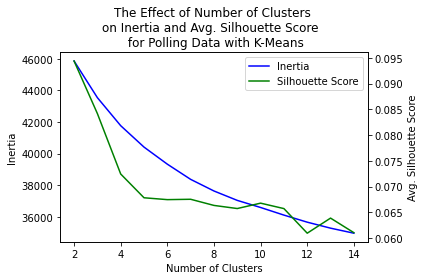

15.932836055755615


In [97]:
start = time.time()

run_kmeans(rca_X_Train_Polling, np.arange(2, 15, 1), "Polling Data")

end = time.time()
elapsed = end - start
print(elapsed)

Step 3.4) Data 1 with K-Means and RFC 

<Figure size 432x288 with 0 Axes>

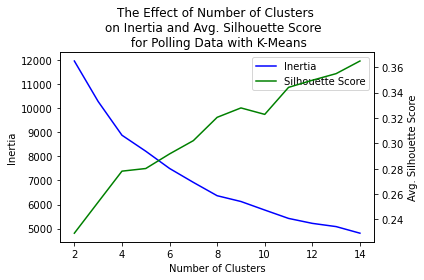

12.547826766967773


In [98]:
start = time.time()

run_kmeans(rfc_X_Train_Polling, np.arange(2, 15, 1), "Polling Data" )

end = time.time()
elapsed = end - start
print(elapsed)

### Step 3) Data 1 With EM

3.5) Data 1 With EM with PCA 

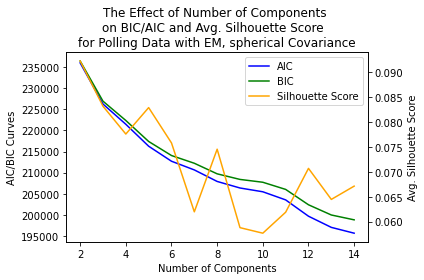

11.88600778579712


In [99]:
start = time.time()

run_em(pca_X_Train_Polling, np.arange(2, 15, 1), "Polling Data", 'spherical')

end = time.time()
elapsed = end - start
print(elapsed)

Data 1, EM, ICA

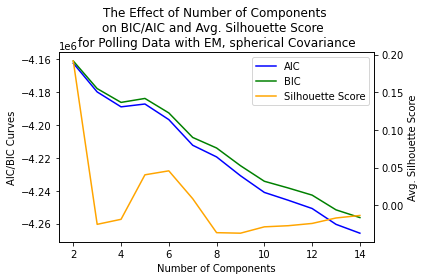

12.135259866714478


In [100]:
start = time.time()

run_em(ica_X_Train_Polling, np.arange(2, 15, 1), "Polling Data", 'spherical')

end = time.time()
elapsed = end - start
print(elapsed)

Data 1, EM, RCA

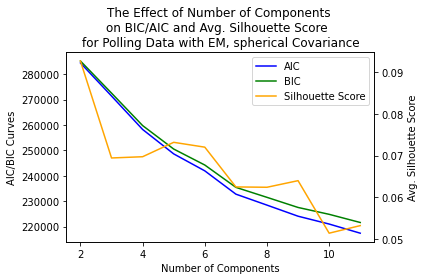

8.6303391456604


In [101]:
start = time.time()

run_em(rca_X_Train_Polling, np.arange(2, 12, 1), "Polling Data", 'spherical')

end = time.time()
elapsed = end - start
print(elapsed)

Data 1, EM, RFC

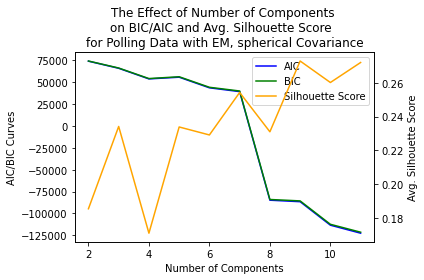

8.570395946502686


In [102]:
start = time.time()

run_em(rfc_X_Train_Polling, np.arange(2, 12, 1), "Polling Data", 'spherical')

end = time.time()
elapsed = end - start
print(elapsed)

### Step 3) Data 2

In [103]:
pca_X_Train_Income = PCA(n_components = 19, random_state = 42).fit_transform(X_Train_Income)
ica_X_Train_Income = ICA(n_components = 58, random_state = 42).fit_transform(X_Train_Income)
rca_X_Train_Income = GRP(n_components = 47, random_state = 42).fit_transform(X_Train_Income)

top_cols_df, top_cols = run_RFC(X_Train_Income, Y_Train_Income, 47)
rfc_X_Train_Income = X_Train_Income[top_cols] 

Data 1, PCA, KMeans

<Figure size 432x288 with 0 Axes>

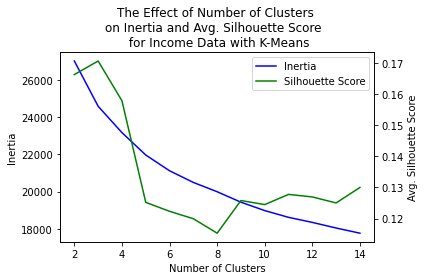

12.576856136322021


In [104]:
start = time.time()

run_kmeans(pca_X_Train_Income, np.arange(2, 15, 1), "Income Data")

end = time.time()
elapsed = end - start
print(elapsed)

<Figure size 432x288 with 0 Axes>

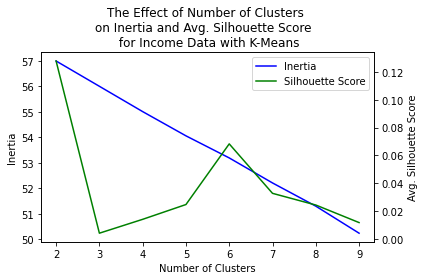

8.349256992340088


In [105]:
start = time.time()

run_kmeans(ica_X_Train_Income, np.arange(2, 10, 1), "Income Data")

end = time.time()
elapsed = end - start
print(elapsed)

<Figure size 432x288 with 0 Axes>

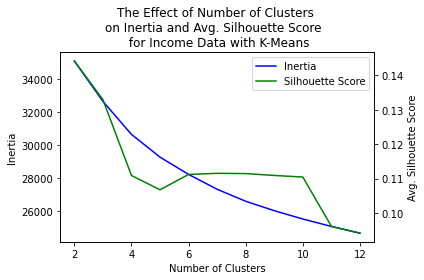

11.788591861724854


In [106]:
start = time.time()

run_kmeans(rca_X_Train_Income, np.arange(2, 13, 1), "Income Data")

end = time.time()
elapsed = end - start
print(elapsed)

<Figure size 432x288 with 0 Axes>

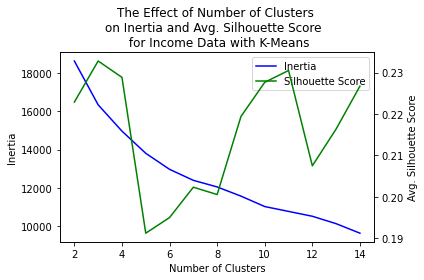

11.48385214805603


In [107]:
start = time.time()

run_kmeans(rfc_X_Train_Income, np.arange(2, 15, 1), "Income Data")

end = time.time()
elapsed = end - start
print(elapsed)

Data 2 on EM

PCA

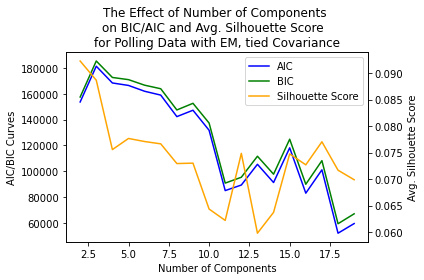

21.90704894065857


In [108]:
start = time.time()

run_em(pca_X_Train_Polling, np.arange(2, 20, 1), "Polling Data", 'tied')

end = time.time()
elapsed = end - start
print(elapsed)

ICA

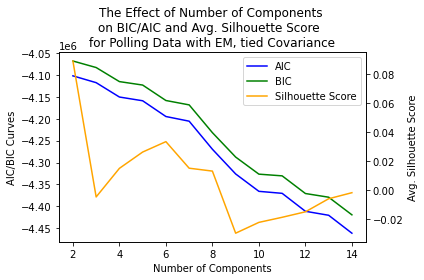

13.899627685546875


In [109]:
start = time.time()

run_em(ica_X_Train_Polling, np.arange(2, 15, 1), "Polling Data", 'tied')

end = time.time()
elapsed = end - start
print(elapsed)

RCA

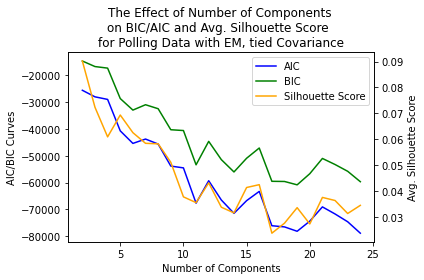

40.75596475601196


In [110]:
start = time.time()

run_em(rca_X_Train_Polling, np.arange(2, 25, 1), "Polling Data", 'tied')

end = time.time()
elapsed = end - start
print(elapsed)

RFC

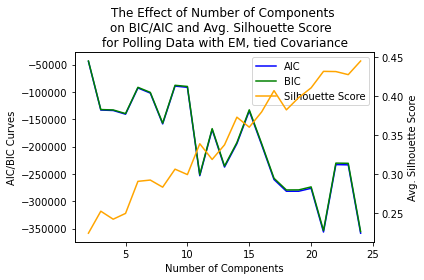

21.139999866485596


In [111]:
start = time.time()

run_em(rfc_X_Train_Polling, np.arange(2, 25, 1), "Polling Data", 'tied')

end = time.time()
elapsed = end - start
print(elapsed)

### Step 4: Use the Dimensionalty Reduced Datasets, Run Neural Networks 

In [112]:
pca_X_Train_Polling.shape

(7000, 31)

In [113]:
from sklearn.neural_network import MLPClassifier 
from sklearn.metrics import confusion_matrix

def make_ann_dimred(pca_X_Train_Polling, Y_Train_Polling, hidden_layer_sizes, activation, solver, LR_init):
    
    X_Train, X_Test, Y_Train, Y_Test = train_test_split(pca_X_Train_Polling, Y_Train_Polling, test_size=0.30, random_state=42)


    classifier = MLPClassifier(random_state=42,
                                       learning_rate_init = LR_init, 
                                       hidden_layer_sizes = (hidden_layer_sizes,),
                                       activation = activation, solver=solver, max_iter=200)

    classifier.fit(X_Train, Y_Train)


    Y_Pred = classifier.predict(X_Test)
    cm = confusion_matrix(Y_Test, Y_Pred)
    tn, fp, fn, tp = confusion_matrix(Y_Test, Y_Pred).ravel()
    f1_score = (2*tp) / (2*tp + fp + fn)
    #print(f1_score)
    return(f1_score)
    #f1_scores_test.append(f1_score)

    #Y_Pred = classifier.predict(X_Train)
    #cm = confusion_matrix(Y_Train, Y_Pred)
    #tn, fp, fn, tp = confusion_matrix(Y_Train, Y_Pred).ravel()
    #f1_score = (2*tp) / (2*tp + fp + fn)
    #print(f1_score)
    #f1_scores_train.append(f1_score)


Data #1

#### Activation Function

PCA

In [ ]:
activation_functions = ['identity', 'tanh', 'relu', 'logistic' ]

for activation in activation_functions:
    print("F1 Score:", make_ann_dimred(pca_X_Train_Polling, Y_Train_Polling, 156, activation, 'adam', 0.01), \
         "Activation: ", activation)


ICA

In [ ]:
activation_functions = ['identity', 'tanh', 'relu', 'logistic' ]

for activation in activation_functions:
    print("F1 Score:", make_ann_dimred(ica_X_Train_Polling, Y_Train_Polling, 156, activation, 'adam', 0.01), \
         "Activation: ", activation)


RCA

In [ ]:
activation_functions = ['identity', 'tanh', 'relu', 'logistic' ]

for activation in activation_functions:
    print("F1 Score:", make_ann_dimred(rca_X_Train_Polling, Y_Train_Polling, 156, activation, 'adam', 0.01), \
         "Activation: ", activation)


RFC

In [ ]:
activation_functions = ['identity', 'tanh', 'relu', 'logistic' ]

for activation in activation_functions:
    print("F1 Score:", make_ann_dimred(rfc_X_Train_Polling, Y_Train_Polling, 156, activation, 'adam', 0.01), \
         "Activation: ", activation)


In [ ]:
print("PCA:", make_ann_dimred(pca_X_Train_Polling, Y_Train_Polling, 156, 'identity', 'adam', 0.01))
print("ICA:", make_ann_dimred(ica_X_Train_Polling, Y_Train_Polling, 156, 'tanh', 'adam', 0.01))
print("RCA:", make_ann_dimred(rca_X_Train_Polling, Y_Train_Polling, 156, 'identity', 'adam', 0.01))
print("RFC:", make_ann_dimred(rfc_X_Train_Polling, Y_Train_Polling, 156, 'tanh', 'adam', 0.01))

#### Hidden Layer Sizes

PCA

In [ ]:
f1_score_list = []
hidden_layers_list = np.arange(50, 200, 10)

for HL in hidden_layers_list:
    f1_score = make_ann_dimred(pca_X_Train_Polling, Y_Train_Polling, HL, 'identity', 'adam', 0.01)
    f1_score_list.append(f1_score)

print(f1_score_list)

plt.clf()
plt.plot(hidden_layers_list, f1_score_list)
plt.xlabel("Size of Hidden Layer")
plt.ylabel("F1 Score")
plt.title("The effect of Hidden Layer Size \non F1 Score for PCA")
plt.show()   

ICA

In [ ]:
f1_score_list = []
hidden_layers_list = np.arange(50, 200, 10)

for HL in hidden_layers_list:
    f1_score = make_ann_dimred(ica_X_Train_Polling, Y_Train_Polling, HL, 'tanh', 'adam', 0.01)
    f1_score_list.append(f1_score)

print(f1_score_list)

plt.clf()
plt.plot(hidden_layers_list, f1_score_list)
plt.xlabel("Size of Hidden Layer")
plt.ylabel("F1 Score")
plt.title("The effect of Hidden Layer Size \non F1 Score for ICA")
plt.show()   

RCA

In [ ]:
f1_score_list = []
hidden_layers_list = np.arange(50, 200, 10)

for HL in hidden_layers_list:
    f1_score = make_ann_dimred(rca_X_Train_Polling, Y_Train_Polling, HL, 'identity', 'adam', 0.01)
    f1_score_list.append(f1_score)

print(f1_score_list)

plt.clf()
plt.plot(hidden_layers_list, f1_score_list)
plt.xlabel("Size of Hidden Layer")
plt.ylabel("F1 Score")
plt.title("The effect of Hidden Layer Size \non F1 Score for RCA")
plt.show()   

RFC

In [ ]:
f1_score_list = []
hidden_layers_list = np.arange(50, 200, 10)

for HL in hidden_layers_list:
    f1_score = make_ann_dimred(rfc_X_Train_Polling, Y_Train_Polling, HL, 'tanh', 'adam', 0.01)
    f1_score_list.append(f1_score)

print(f1_score_list)

plt.clf()
plt.plot(hidden_layers_list, f1_score_list)
plt.xlabel("Size of Hidden Layer")
plt.ylabel("F1 Score")
plt.title("The effect of Hidden Layer Size \non F1 Score for RFC")
plt.show()   

#### Best So far

In [ ]:
print("PCA:", make_ann_dimred(pca_X_Train_Polling, Y_Train_Polling, 170, 'identity', 'adam', 0.01))
print("ICA:", make_ann_dimred(ica_X_Train_Polling, Y_Train_Polling, 120, 'tanh', 'adam', 0.01))
print("RCA:", make_ann_dimred(rca_X_Train_Polling, Y_Train_Polling, 130, 'identity', 'adam', 0.01))
print("RFC:", make_ann_dimred(rfc_X_Train_Polling, Y_Train_Polling, 170, 'tanh', 'adam', 0.01))

#### Initial Learning Rate

PCA

In [ ]:
f1_score_list = []
init_LR_list = [0.0001, 0.001, 0.01, 0.05, 0.10, 0.50]

for LR in init_LR_list:
    f1_score = make_ann_dimred(pca_X_Train_Polling, Y_Train_Polling, 170, 'identity', 'adam', LR)
    f1_score_list.append(f1_score)

print(f1_score_list)

plt.clf()
plt.plot(init_LR_list, f1_score_list)
plt.xlabel("Initial Learning Rate")
plt.ylabel("F1 Score")
plt.title("The effect of initial learning rate \non F1 Score for PCA")
plt.show()   

ICA

In [ ]:
f1_score_list = []
init_LR_list = [0.0001, 0.001, 0.01, 0.05, 0.10, 0.50]

for LR in init_LR_list:
    f1_score = make_ann_dimred(ica_X_Train_Polling, Y_Train_Polling, 120, 'tanh', 'adam', LR)
    f1_score_list.append(f1_score)

print(f1_score_list)
 
plt.clf()
plt.plot(init_LR_list, f1_score_list)
plt.xlabel("Initial Learning Rate")
plt.ylabel("F1 Score")
plt.title("The effect of initial learning rate \non F1 Score for ICA")
plt.show()   

RCA

In [ ]:
f1_score_list = []
init_LR_list = [0.0001, 0.001, 0.01, 0.05, 0.10, 0.50]

for LR in init_LR_list:
    f1_score = make_ann_dimred(rca_X_Train_Polling, Y_Train_Polling, 130, 'identity', 'adam', LR)
    f1_score_list.append(f1_score)
    
print(f1_score_list)

plt.clf()
plt.plot(init_LR_list, f1_score_list)
plt.xlabel("Initial Learning Rate")
plt.ylabel("F1 Score")
plt.title("The effect of initial learning rate \non F1 Score for RCA")
plt.show()   

RFC

In [ ]:
f1_score_list = []
init_LR_list = [0.0001, 0.001, 0.01, 0.05, 0.10, 0.50]

for LR in init_LR_list:
    f1_score = make_ann_dimred(rfc_X_Train_Polling, Y_Train_Polling, 170, 'tanh', 'adam', LR)
    f1_score_list.append(f1_score)

print(f1_score_list)
 
plt.clf()
plt.plot(init_LR_list, f1_score_list)
plt.xlabel("Initial Learning Rate")
plt.ylabel("F1 Score")
plt.title("The effect of initial learning rate \non F1 Score for RFC")
plt.show()   

#### Best Results

In [ ]:
print("Full:", make_ann_dimred(X_Train_Polling, Y_Train_Polling, 156, 'identity', 'adam', 0.01))

In [ ]:
print("PCA:", make_ann_dimred(pca_X_Train_Polling, Y_Train_Polling, 170, 'identity', 'adam', 0.01))
print("ICA:", make_ann_dimred(ica_X_Train_Polling, Y_Train_Polling, 120, 'tanh', 'adam', 0.05))
print("RCA:", make_ann_dimred(rca_X_Train_Polling, Y_Train_Polling, 130, 'identity', 'adam', 0.01))
print("RFC:", make_ann_dimred(rfc_X_Train_Polling, Y_Train_Polling, 170, 'tanh', 'adam', 0.01))


### Step 5: Apply Clustering Algorithms, then use those labels to feed into a Neural Network

Make one Prediction for KM, and one for EM

Full Dataset with ANN - Baseline

In [ ]:
def make_ann(X_Data, Y_Data):
    
    X_Train, X_Test, Y_Train, Y_Test = train_test_split(X_Data, Y_Data, test_size = .30, train_size = .70, random_state = 42)

    classifier = MLPClassifier(random_state=42,
                                       learning_rate_init = 0.01, 
                                       hidden_layer_sizes = (156,),
                                       activation = 'identity', solver='adam', max_iter=2000)
    classifier.fit(X_Train, Y_Train)
    print("Shape:",X_Train.shape)
    Y_Pred = classifier.predict(X_Test)
    cm = confusion_matrix(Y_Test, Y_Pred)
    tn, fp, fn, tp = confusion_matrix(Y_Test, Y_Pred).ravel()
    f1_score = (2*tp) / (2*tp + fp + fn)
    print("F1 Score:",f1_score)

In [ ]:
start = time.time()

make_ann(X_Train_Polling, Y_Train_Polling)

end = time.time()
elapsed = end-start
print("Runtime:",elapsed)

KMeans

In [ ]:
def make_ann_kmeans(X_Data, Y_Data, KM_Clusters):

    kmeans =  KMeans(n_clusters = 10, init = 'k-means++', n_init = 10, random_state = 42)
    kmeans_labels = kmeans.fit_predict(X_Data)

    kmeans_labels = pd.DataFrame(kmeans_labels, columns = ['KM'])

    # Add the NN Labels Here:
    X_Train, X_Test, Y_Train, Y_Test = prep_data(kmeans_labels, Y_Data, ['KM'])

    classifier = MLPClassifier(random_state=42,
                                       learning_rate_init = 0.01, 
                                       hidden_layer_sizes = (156,),
                                       activation = 'identity', solver='adam', max_iter=2000)
    classifier.fit(X_Train, Y_Train)
    print("Shape:",X_Train.shape)
    Y_Pred = classifier.predict(X_Test)
    cm = confusion_matrix(Y_Test, Y_Pred)
    tn, fp, fn, tp = confusion_matrix(Y_Test, Y_Pred).ravel()
    f1_score = (2*tp) / (2*tp + fp + fn)
    print("F1 Score:",f1_score)

In [ ]:
start = time.time()

make_ann_kmeans(X_Train_Polling, Y_Train_Polling, 10)

end = time.time()
elapsed = end-start
print("Runtime:",elapsed)

EM

In [ ]:
def make_ann_em(X_Data, Y_Data, EM_Clusters):
  
    em = EM(n_components = 8, covariance_type = 'spherical', n_init = 1, init_params = 'kmeans', random_state = 42)
    em_labels = em.fit_predict(X_Data)

    em_labels = pd.DataFrame(em_labels, columns = ['EM'])

    # Add the NN Labels Here:
    X_Train, X_Test, Y_Train, Y_Test = prep_data(em_labels, Y_Data, ['EM'])

    classifier = MLPClassifier(random_state=42,
                                       learning_rate_init = 0.01, 
                                       hidden_layer_sizes = (156,),
                                       activation = 'identity', solver='adam', max_iter=200)
    classifier.fit(X_Train, Y_Train)
    print("Shape:",X_Train.shape)
    Y_Pred = classifier.predict(X_Test)
    cm = confusion_matrix(Y_Test, Y_Pred)
    tn, fp, fn, tp = confusion_matrix(Y_Test, Y_Pred).ravel()
    f1_score = (2*tp) / (2*tp + fp + fn)
    print("F1 Score:",f1_score)

In [ ]:
start = time.time()

make_ann_em(X_Train_Polling, Y_Train_Polling, 8)

end = time.time()
elapsed = end-start
print("Runtime:",elapsed)

Add KM and EM Cluster Labels to the Original Dataset: an Augmentation

#### KMeans Augmented

In [ ]:
def make_ann_kmeans_augment(X_Data, Y_Data):
    
    kmeans =  KMeans(n_clusters = 10, init = 'k-means++', n_init = 10, random_state = 42)
    kmeans_labels = kmeans.fit_predict(X_Data)

    kmeans_labels = pd.DataFrame(kmeans_labels, columns = ['KM'])

    # Must RESET INDEX 
    X_New = pd.concat([X_Data.reset_index(drop=True), kmeans_labels.reset_index(drop=True)], axis=1)

    # Add the NN Labels Here:
    X_Train, X_Test, Y_Train, Y_Test = prep_data(X_New, Y_Data, ['KM'])

    classifier = MLPClassifier(random_state=42,
                                       learning_rate_init = 0.01, 
                                       hidden_layer_sizes = (156,),
                                       activation = 'identity', solver='adam', max_iter=2000)
    classifier.fit(X_Train, Y_Train)
    
    print("Shape:", X_Train.shape)
    
    Y_Pred = classifier.predict(X_Test)
    cm = confusion_matrix(Y_Test, Y_Pred)
    tn, fp, fn, tp = confusion_matrix(Y_Test, Y_Pred).ravel()
    f1_score = (2*tp) / (2*tp + fp + fn)
    print("F1 Score:", f1_score)

In [ ]:
start = time.time()

make_ann_kmeans_augment(X_Train_Polling, Y_Train_Polling)

end = time.time()
elapsed = end-start
print("Runtime:",elapsed)

#### EM Augmented

In [ ]:
def make_ann_em_augment(X_Data, Y_Data):
    
    em = EM(n_components = 8, covariance_type = 'spherical', n_init = 1, init_params = 'kmeans', random_state = 42)
    em_labels = em.fit_predict(X_Data)

    em_labels = pd.DataFrame(em_labels, columns = ['EM'])

    # Must RESET INDEX 
    X_New = pd.concat([X_Data.reset_index(drop=True), em_labels.reset_index(drop=True)], axis=1)

    # Add the NN Labels Here:
    X_Train, X_Test, Y_Train, Y_Test = prep_data(X_New, Y_Data, ['EM'])

    classifier = MLPClassifier(random_state=42,
                                       learning_rate_init = 0.01, 
                                       hidden_layer_sizes = (156,),
                                       activation = 'identity', solver='adam', max_iter=2000)
    classifier.fit(X_Train, Y_Train)
    
    print("Shape:", X_Train.shape)
    
    Y_Pred = classifier.predict(X_Test)
    cm = confusion_matrix(Y_Test, Y_Pred)
    tn, fp, fn, tp = confusion_matrix(Y_Test, Y_Pred).ravel()
    f1_score = (2*tp) / (2*tp + fp + fn)
    print("F1 Score:", f1_score)

In [ ]:
start = time.time()

make_ann_em_augment(X_Train_Polling, Y_Train_Polling)

end = time.time()
elapsed = end-start
print("Runtime:", elapsed)